In [1]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm
import torch
from weaver.nn.model.ParticleTransformer import ParticleTransformer
from weaver.utils.logger import _logger
import torch.optim as optim


In [2]:
def build_features_and_labels(tree, transform_features=True):
    
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log', 
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)
    
    return out

In [3]:
def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

In [4]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


In [5]:
tree = uproot.open('JetClass_example_100k.root')['tree']

In [6]:
table = build_features_and_labels(tree)


In [7]:
x_particles = table['pf_features']
x_jets = table['pf_vectors']
y = table['label']
x_points = table['pf_points']
x_mask = table['pf_mask']

In [8]:
x_jets.shape

(100000, 4, 128)

In [9]:
x_jets.shape

(100000, 4, 128)

In [10]:
r_indexes = np.arange(len(x_particles))
np.random.shuffle(r_indexes)


In [11]:
x_particles_train=x_particles[r_indexes][0:10000]
x_jets_train=x_jets[r_indexes][0:10000]
y_train=y[r_indexes][0:10000]
x_points_train=x_points[r_indexes][0:10000]
x_mask_train=x_mask[r_indexes][0:10000]

In [12]:
x_part_test=x_particles[r_indexes][20000:21000]
x_jet_test=x_jets[r_indexes][20000:21000]
y_test=y[r_indexes][20000:21000]
x_points_test=x_points[r_indexes][20000:21000]
x_mask_test=x_mask[r_indexes][20000:21000]

In [48]:
np.save('x_particles_trainer', x_particles_train)
np.save('x_jets_trainer', x_jets_train)
np.save('y_trainer', y_train)
np.save('x_points_trainer', x_points_train)
np.save('x_mask_trainer', x_mask_train)
np.save('x_part_tester', x_part_test)
np.save('x_jet_tester', x_jet_test)
np.save('y_tester', y_test)
np.save('x_points_tester', x_points_test)
np.save('x_mask_tester',x_mask_test)

In [49]:
class ParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = ParticleTransformer(**kwargs)
        self.attention_matrix = None 
        self.interactionMatrix = None
    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        output = self.mod(features, v=lorentz_vectors, mask=mask)
        self.attention_matrix = self.mod.getAttention()
        self.interactionMatrix = self.mod.getInteraction()
        return output
        
    
    def get_attention_matrix(self):
        return self.attention_matrix
    def get_interactionMatrix(self):
        return self.interactionMatrix

def get_model(**kwargs):

    cfg = dict(
        input_dim=17,
        num_classes=10,
        # network configurations
        pair_input_dim=4,
        use_pre_activation_pair=False,
        embed_dims=[64, 64, 64],
        pair_embed_dims= [32,32,32],
        num_heads=1,
        num_layers=1,
        num_cls_layers=1,
        block_params=None,
        cls_block_params={'dropout': 0.2, 'attn_dropout': 0.2, 'activation_dropout': 0.2},
        fc_params=[],
        activation='gelu',
        # misc
        trim=True,
        for_inference=False,
    )
    cfg.update(**kwargs)
    _logger.info('Model config: %s' % str(cfg))

    model = ParticleTransformerWrapper(**cfg)

    model_info = {

    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [50]:
model= get_model()

2024-04-25 12:10:11 | INFO | weaver | Model config: {'input_dim': 17, 'num_classes': 10, 'pair_input_dim': 4, 'use_pre_activation_pair': False, 'embed_dims': [64, 64, 64], 'pair_embed_dims': [32, 32, 32], 'num_heads': 1, 'num_layers': 1, 'num_cls_layers': 1, 'block_params': None, 'cls_block_params': {'dropout': 0.2, 'attn_dropout': 0.2, 'activation_dropout': 0.2}, 'fc_params': [], 'activation': 'gelu', 'trim': True, 'for_inference': False}
2024-04-25 12:10:11 | INFO | weaver | cfg_block: {'embed_dim': 64, 'num_heads': 1, 'ffn_ratio': 4, 'dropout': 0.1, 'attn_dropout': 0.1, 'activation_dropout': 0.1, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}
2024-04-25 12:10:11 | INFO | weaver | cfg_cls_block: {'embed_dim': 64, 'num_heads': 1, 'ffn_ratio': 4, 'dropout': 0.2, 'attn_dropout': 0.2, 'activation_dropout': 0.2, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True

In [51]:
total_params = sum(p.numel() for p in model[0].parameters())


In [52]:
total_params

114523

In [53]:
model

(ParticleTransformerWrapper(
   (mod): ParticleTransformer(
     (trimmer): SequenceTrimmer()
     (embed): Embed(
       (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (embed): Sequential(
         (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
         (1): Linear(in_features=17, out_features=64, bias=True)
         (2): GELU(approximate='none')
         (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
         (4): Linear(in_features=64, out_features=64, bias=True)
         (5): GELU(approximate='none')
         (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
         (7): Linear(in_features=64, out_features=64, bias=True)
         (8): GELU(approximate='none')
       )
     )
     (pair_embed): PairEmbed(
       (embed): Sequential(
         (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (1): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
         (2): Batch

In [54]:
from torch.utils.data import Dataset, DataLoader


In [55]:
learning_rate = 1e-4
dataloader = DataLoader(x_particles_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
ydataloader = DataLoader(y_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xjdataloader = DataLoader(x_jets_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xpointloader = DataLoader(x_points_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xmaskloader = DataLoader(x_mask_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [56]:
loss_fn = torch.nn.CrossEntropyLoss()


In [57]:
model[0].aux_logits=False

In [58]:
epochs = 20

In [59]:
y.shape

torch.Size([16, 10])

In [60]:
y_test.shape

(1000, 10)

In [61]:
print(torch.from_numpy(y_test[1]).shape)

torch.Size([10])


In [62]:
x_points_test.shape

(1000, 2, 128)

In [63]:
model

(ParticleTransformerWrapper(
   (mod): ParticleTransformer(
     (trimmer): SequenceTrimmer()
     (embed): Embed(
       (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (embed): Sequential(
         (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
         (1): Linear(in_features=17, out_features=64, bias=True)
         (2): GELU(approximate='none')
         (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
         (4): Linear(in_features=64, out_features=64, bias=True)
         (5): GELU(approximate='none')
         (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
         (7): Linear(in_features=64, out_features=64, bias=True)
         (8): GELU(approximate='none')
       )
     )
     (pair_embed): PairEmbed(
       (embed): Sequential(
         (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (1): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
         (2): Batch

model()

In [259]:
trainloss = np.zeros(30)
valloss = np.zeros(30)
optimizer = optim.Adam(model[0].parameters(), lr=0.0001)

for t in range(1):
    for x,y,z,a,b in zip(dataloader, ydataloader, xjdataloader,xpointloader,xmaskloader):
        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __c|all__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        y_pred = model[0](a.float(), x.float(), z.float(), b.float())
        
        loss = loss_fn(y_pred, y.float())
        

        # Zero the gradients before running the backward pass.
        model[0].zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        trainloss[t] = loss
        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        optimizer.step()
    with torch.no_grad():
        y_pred= model[0](torch.from_numpy(x_points_test),torch.from_numpy(x_part_test),torch.from_numpy(x_jet_test),torch.from_numpy(x_mask_test))
    yloss = loss_fn(y_pred.float(), torch.from_numpy(y_test).float())
    valloss[t] = yloss
    print('Epoch' +' ' +str(t+1) + ' Train Loss:' +str(trainloss[t]))
    print('        ' + 'Val Loss:' + str(valloss[t]))

Epoch 1 Train Loss:0.7900175452232361
        Val Loss:0.9848266243934631


In [260]:
attention = model[0].get_attention_matrix()

In [261]:
attention.shape

torch.Size([1000, 64, 64])

In [262]:
interaction = model[0].get_interactionMatrix()

In [263]:
interaction.shape

torch.Size([1000, 64, 64])

In [264]:
attention = attention.detach().numpy()

In [265]:
nopairattention = model[0].get_attention_matrix()

In [266]:
interaction = interaction.detach().numpy()

In [267]:
max = attention.max()
min = attention.min()

In [268]:
newAttention = (attention - min)/(max-min)

In [269]:
interactionMax = interaction.max()
interactionMin = interaction.min()

In [270]:
newInteraction = (interaction - interactionMin)/(interactionMax-interactionMin)

In [271]:
noPairMax = nopairattention.max()
nopairMin = nopairattention.min()

In [272]:
import scipy 

In [273]:
interaction.shape

(1000, 64, 64)

In [274]:
newNoPAttention = (nopairattention-nopairMin)/(noPairMax-nopairMin)

In [275]:
newAttention.shape

(1000, 64, 64)

In [276]:
newAttention[:,0,:].shape

(1000, 64)

In [277]:
difference = newNoPAttention - newAttention

In [278]:
np.linalg.norm(newInteraction[0,:,:] - newInteraction[1,:,:])

10.124797

In [279]:
newInteraction.shape

(1000, 64, 64)

In [280]:
sum = newInteraction + newAttention

In [281]:
sumMax = sum.max()
sumMin = sum.min()
newSum = (sum-sumMin)/(sumMax-sumMin)

In [282]:
x_part_test[0,0,:]

array([ 2.2756176 ,  1.4971535 ,  1.4871775 ,  1.425619  ,  1.3307711 ,
        1.2114897 ,  1.1063352 ,  0.9289745 ,  0.9282016 ,  0.76141095,
        0.64179105,  0.5941975 ,  0.54396003,  0.3024839 ,  0.26681602,
        0.2206701 ,  0.21820359,  0.19376753,  0.10669703,  0.01913044,
       -0.03445598, -0.13235225, -0.1498776 , -0.19545498, -0.2779891 ,
       -0.28968745, -0.44570154, -0.58142173, -0.6213321 , -0.63159287,
       -0.81492716, -0.8159335 , -0.887591  , -0.961651  , -1.0493762 ,
       -1.0822129 , -1.156023  ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [283]:
#model with pairs
distanceTot = 0
pearsonTot = 0 
for x in range(1000):
    num = 0
    for b in np.squeeze(x_mask_test[x]):
        if b == 0:
            break
        num = num + 1
    pearson = scipy.stats.pearsonr(newInteraction[x,0:num,0:num].flatten(), newAttention[x,0:num,0:num].flatten())

    distance = np.linalg.norm(newInteraction[x,0:num,0:num] - newAttention[x,0:num,0:num])
    distanceTot = distanceTot + distance/num
    pearsonTot = pearson[0] + pearsonTot
print(distanceTot/1000)
print(pearsonTot/1000)

    



    






0.1899632237786115
0.6891675661308202


/var/folders/zj/988sh2h5501gdntnynlhn0480000gn/T/ipykernel_24580/4126087420.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (15,15))


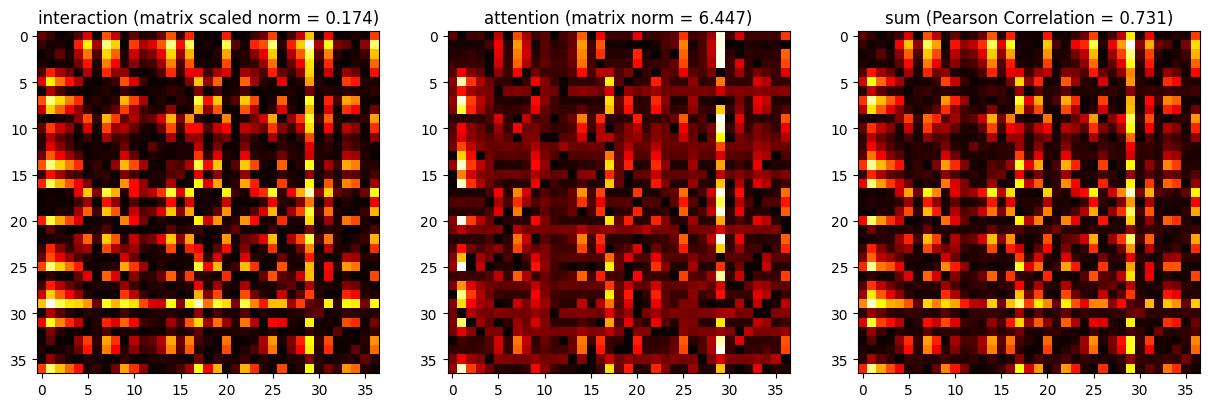

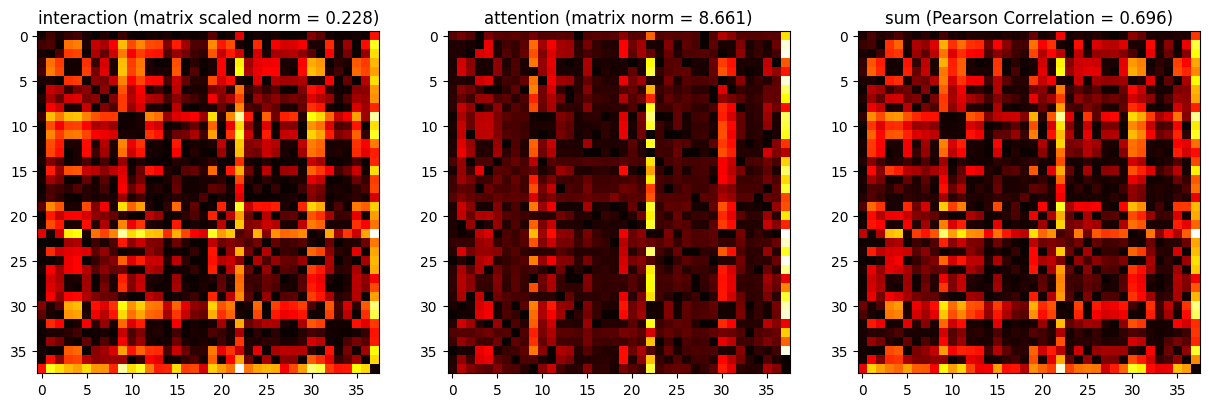

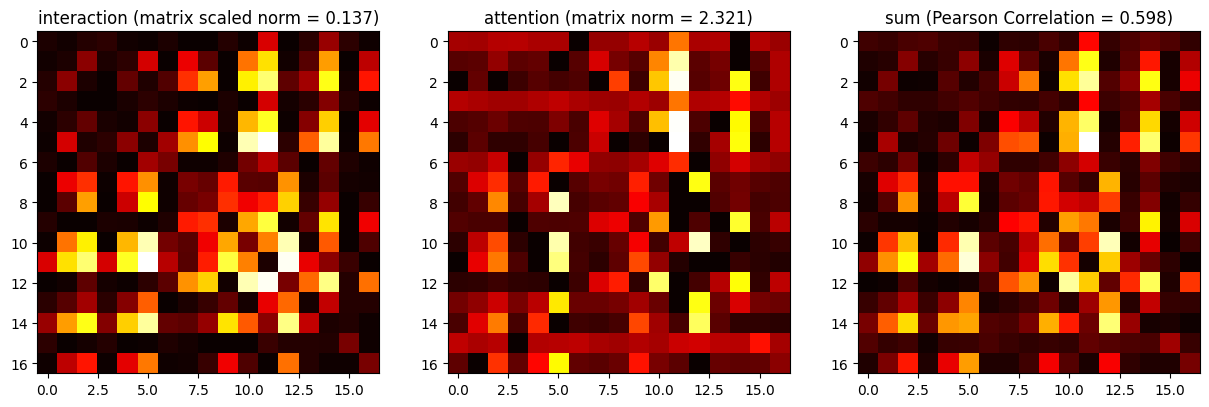

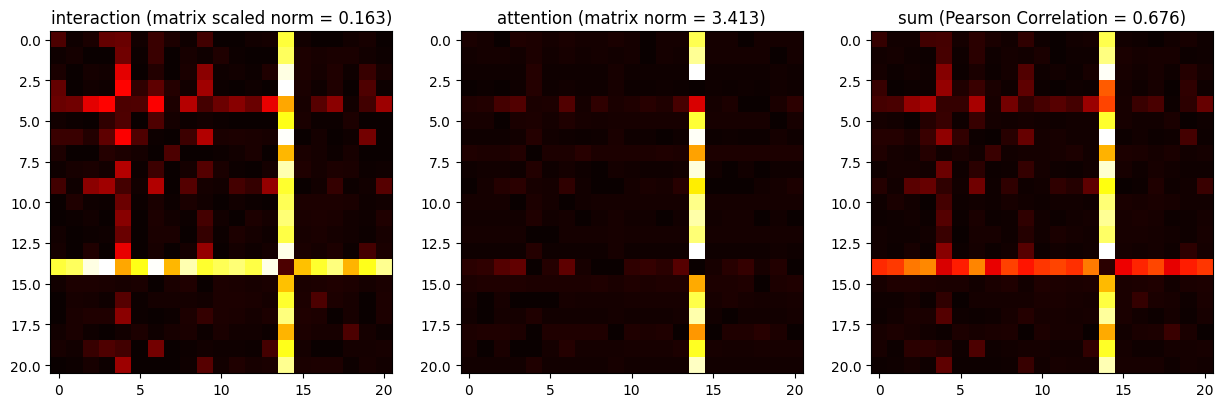

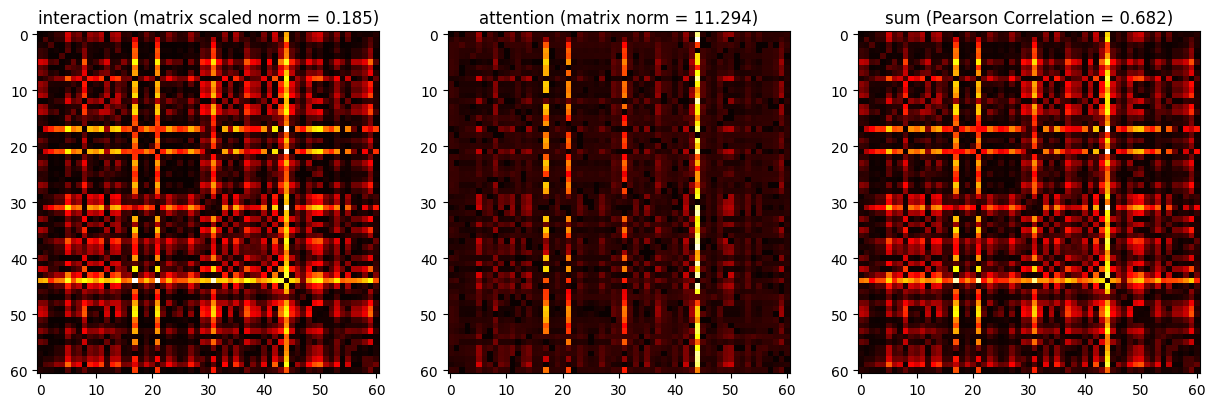

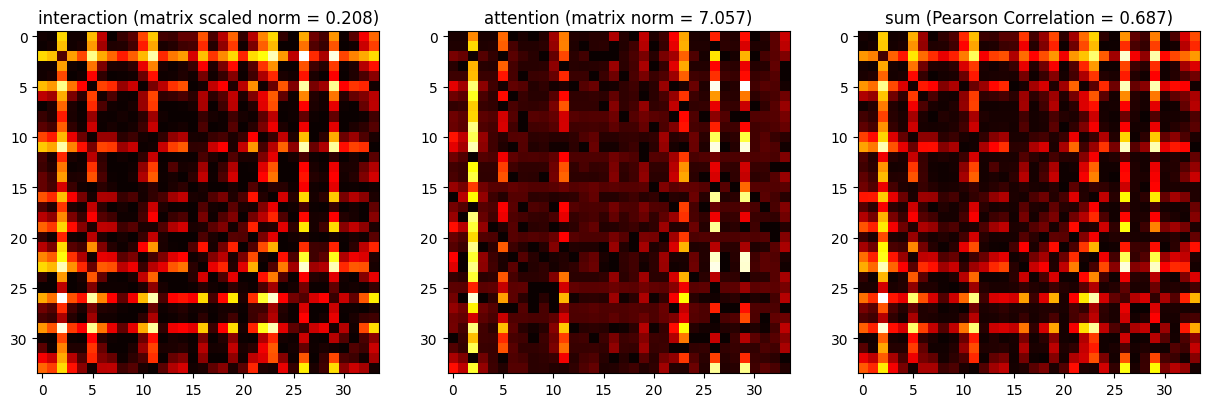

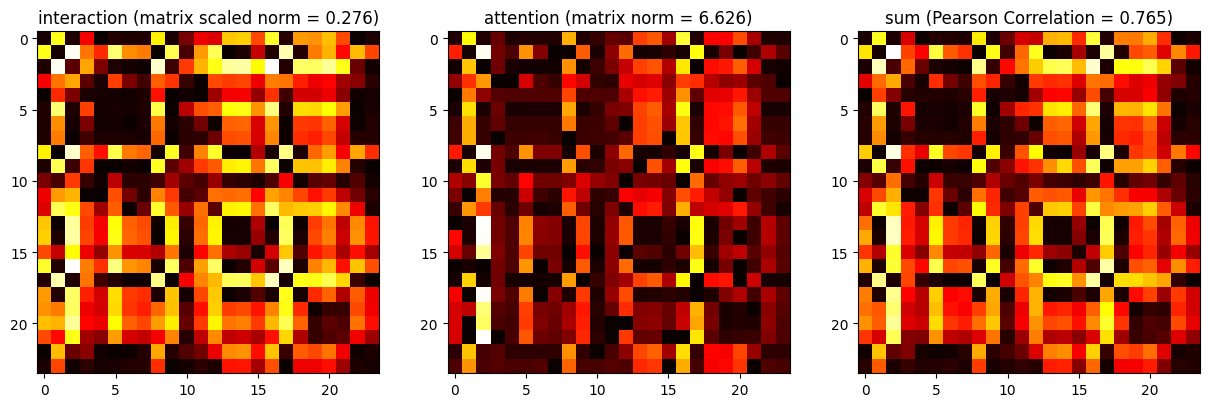

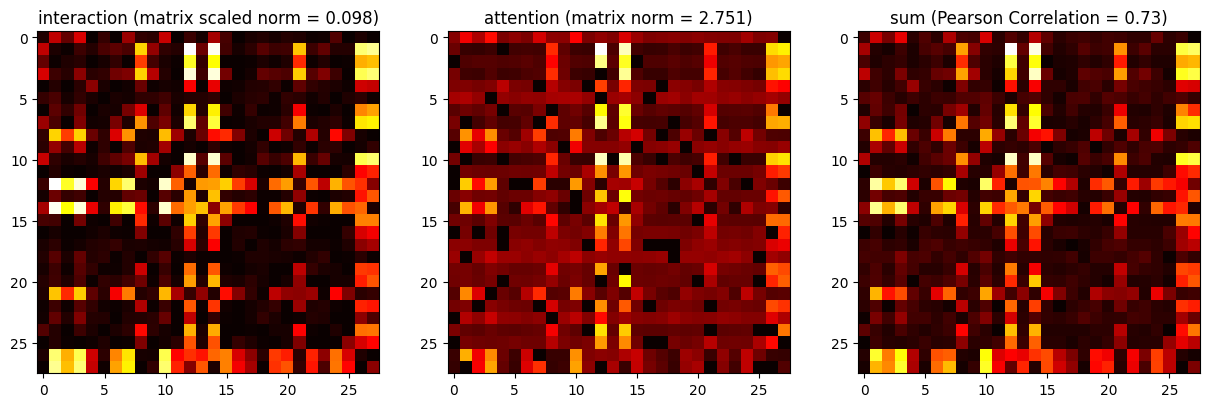

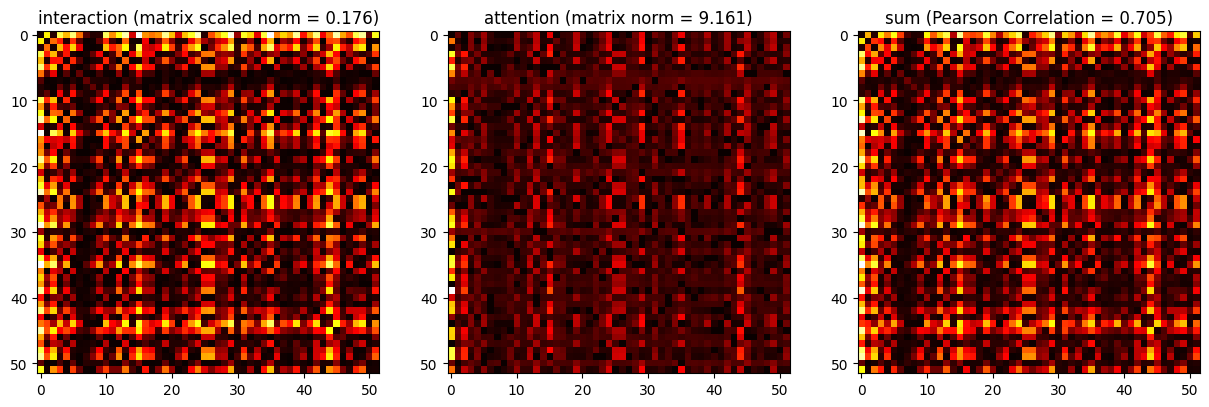

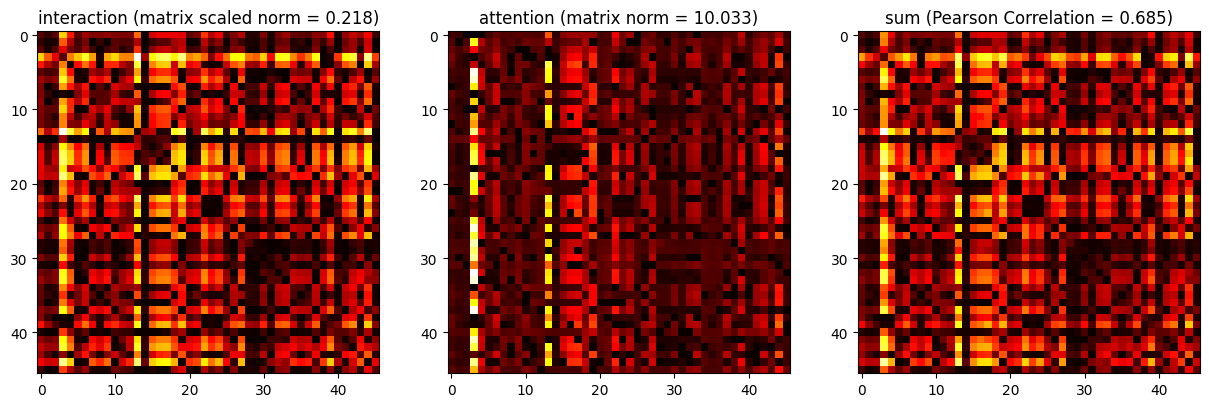

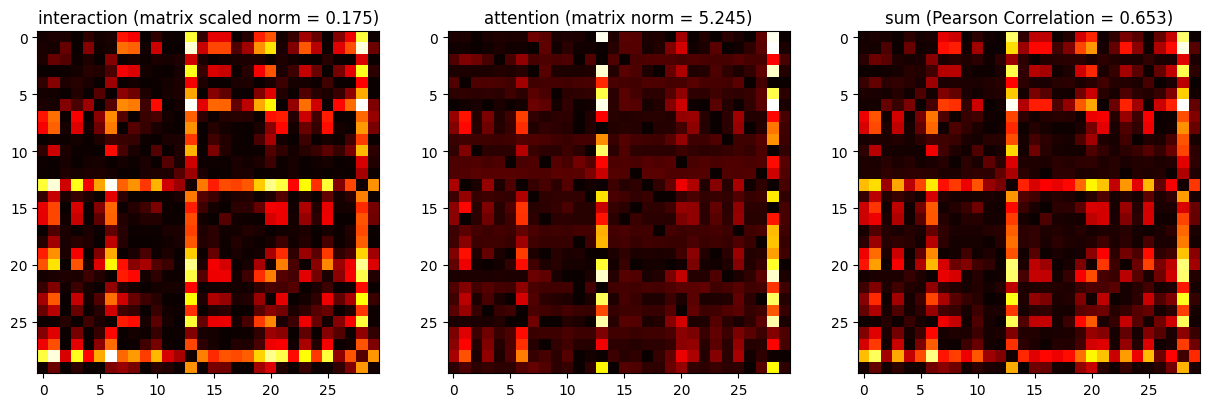

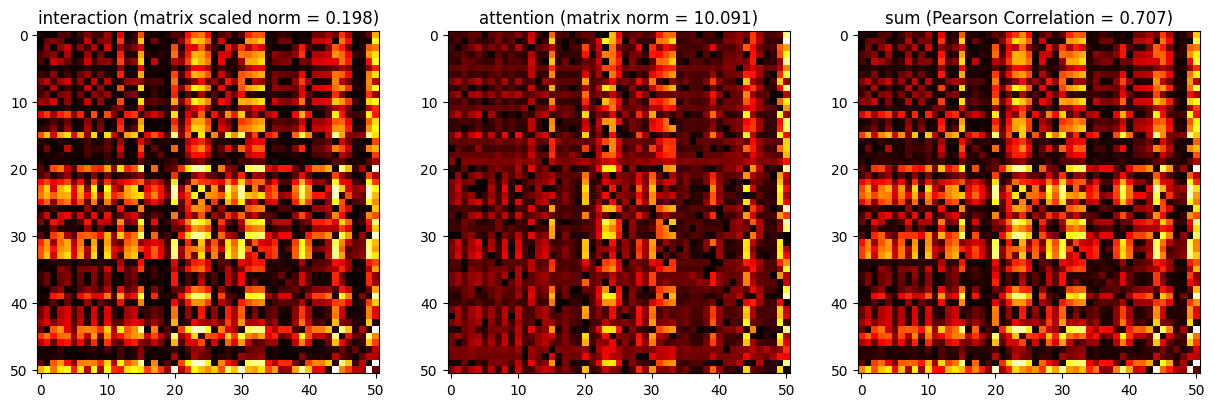

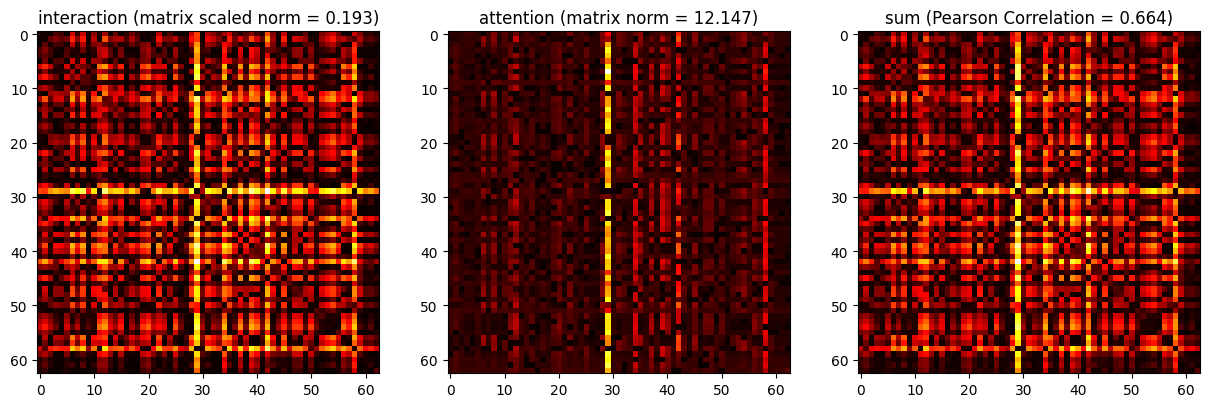

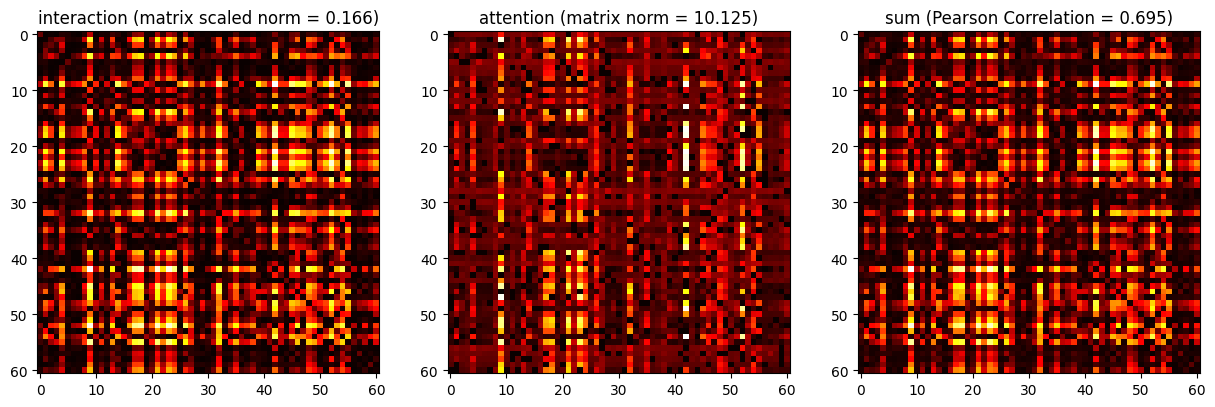

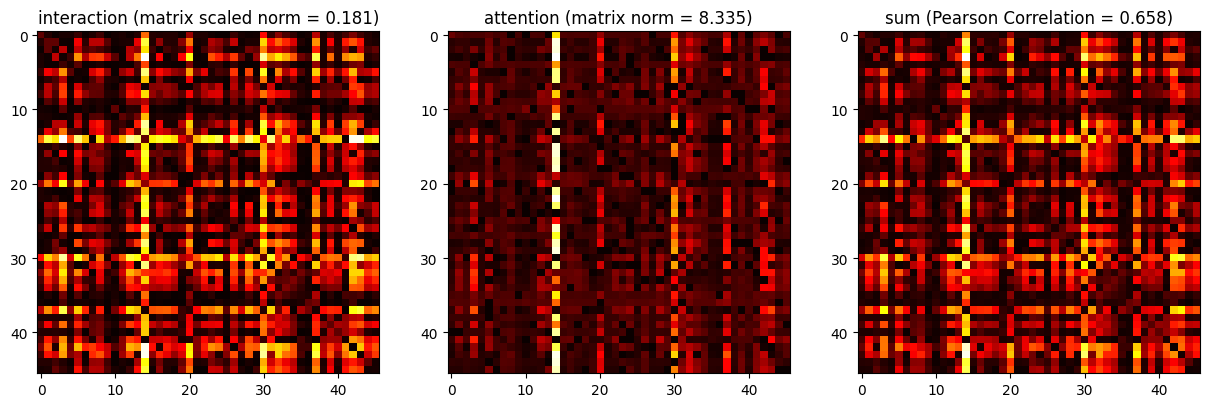

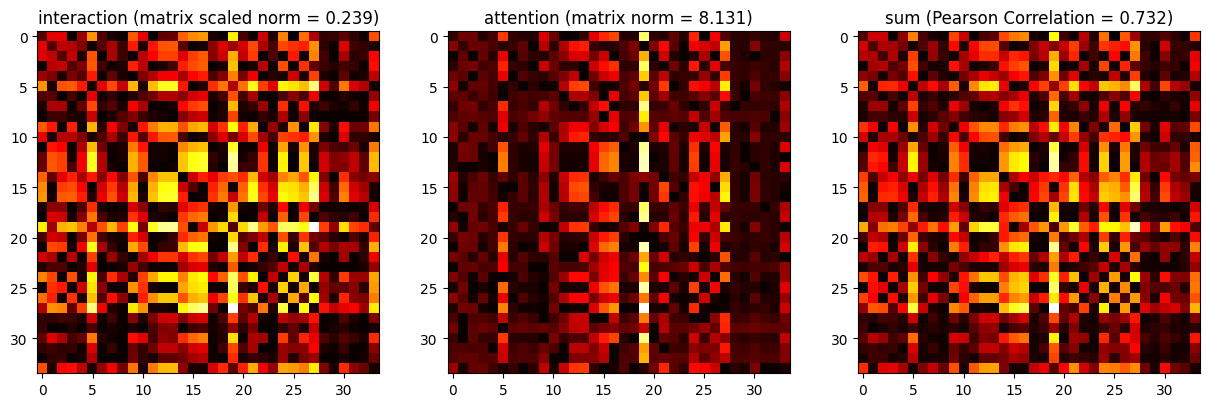

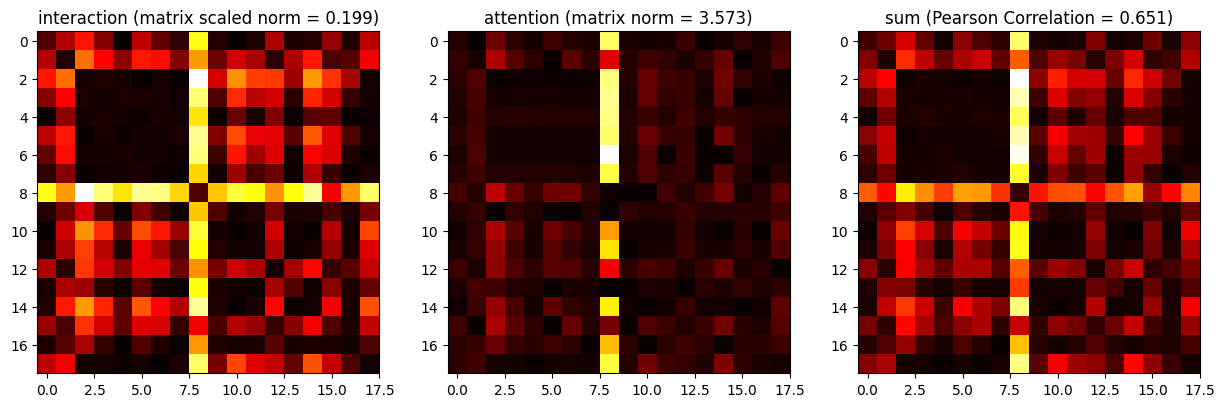

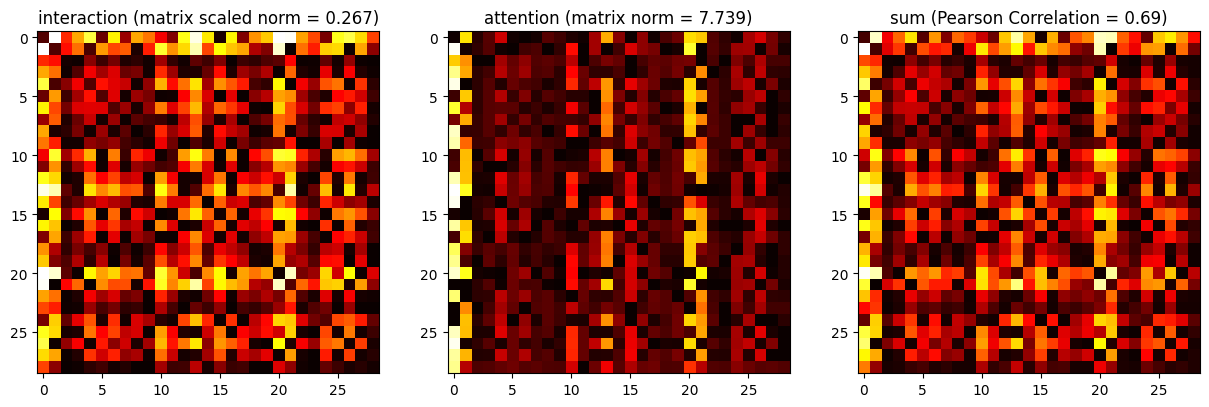

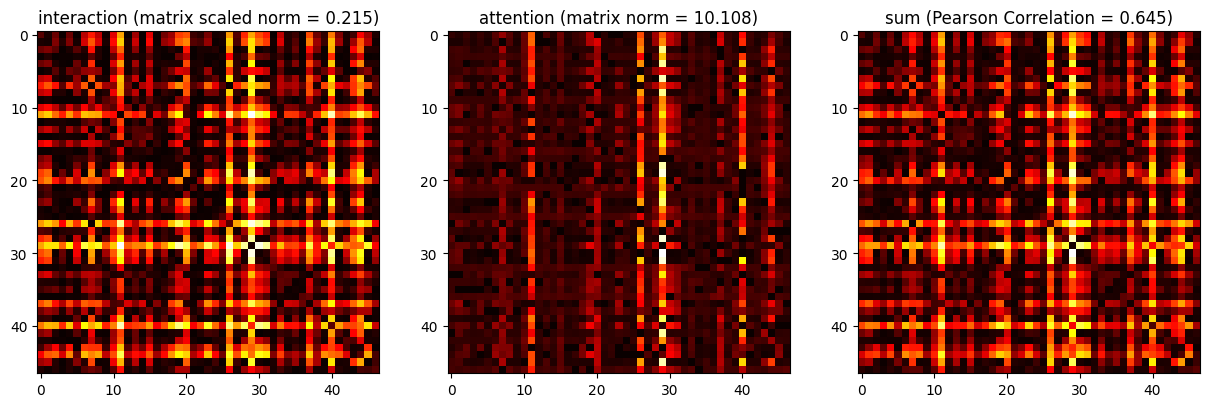

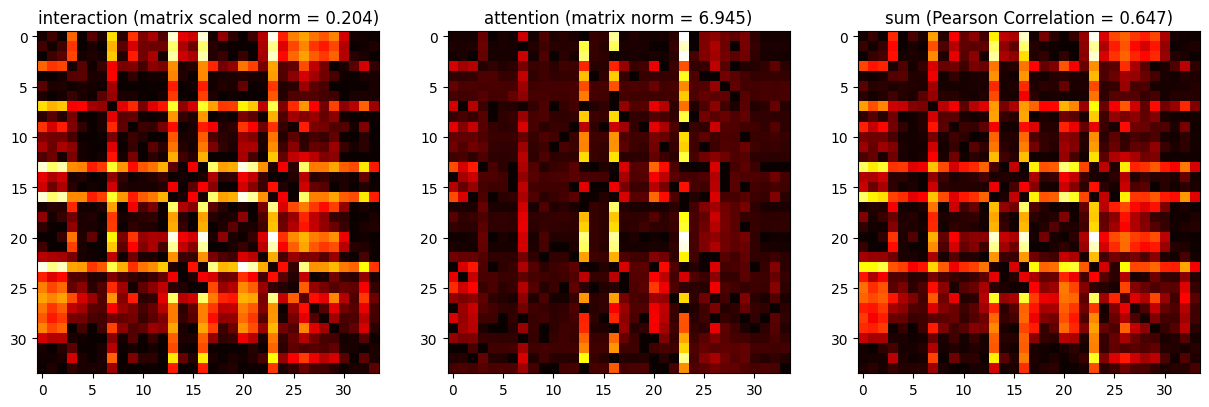

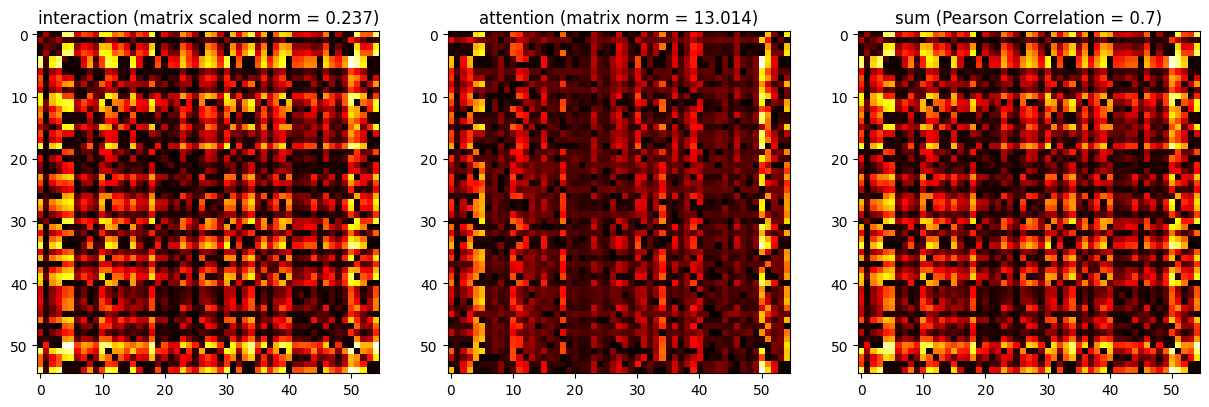

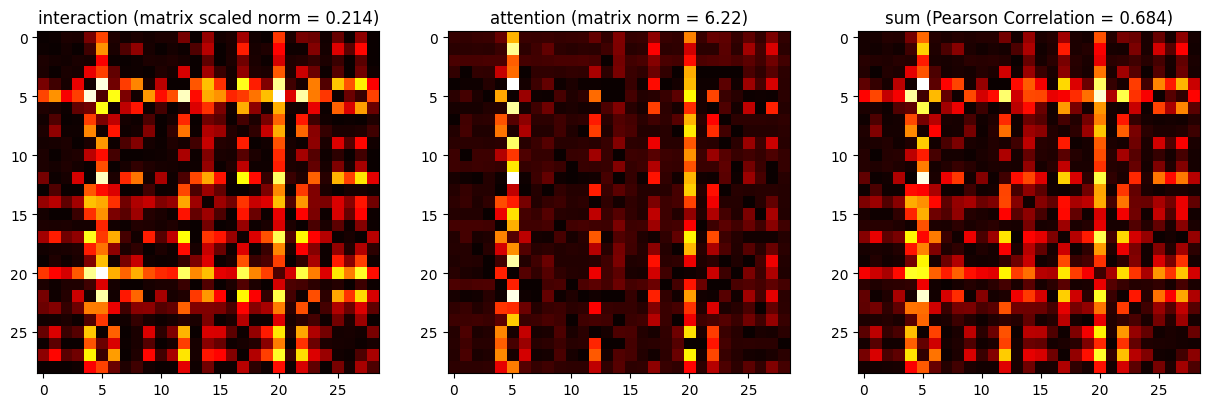

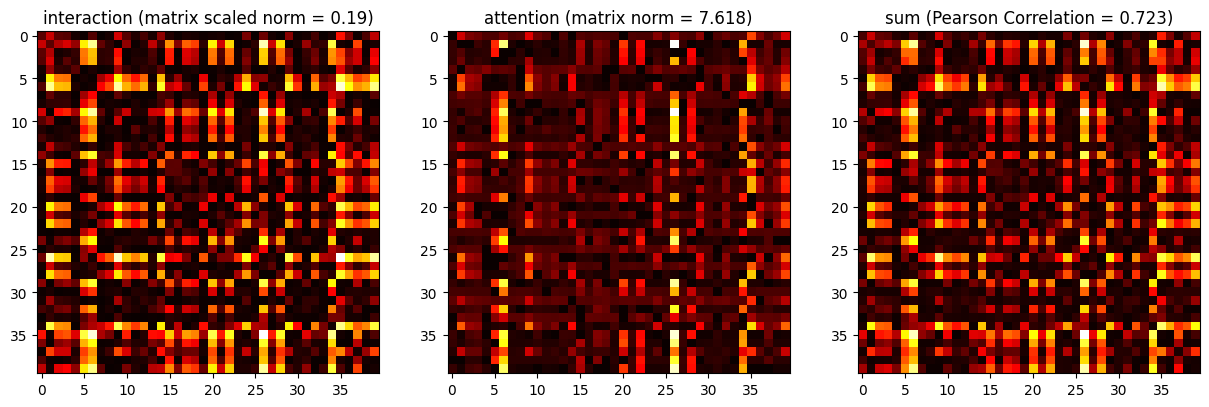

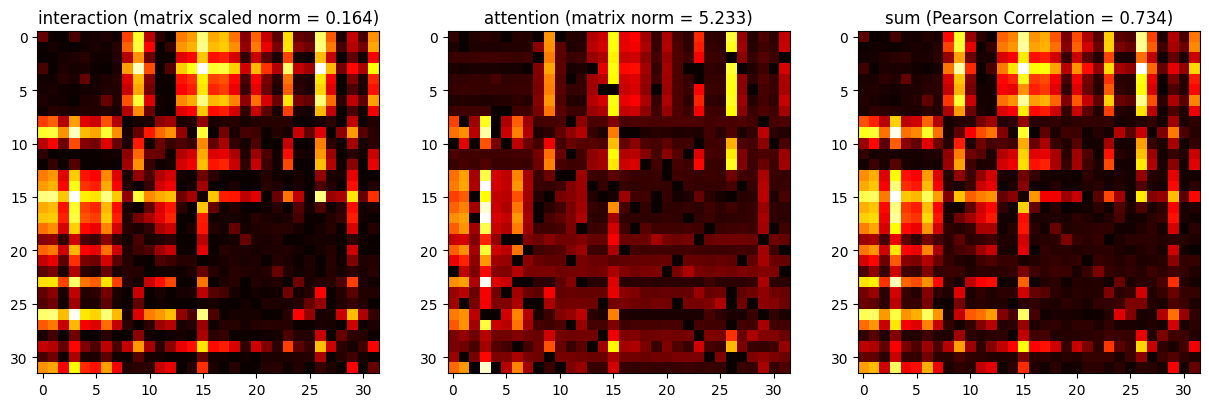

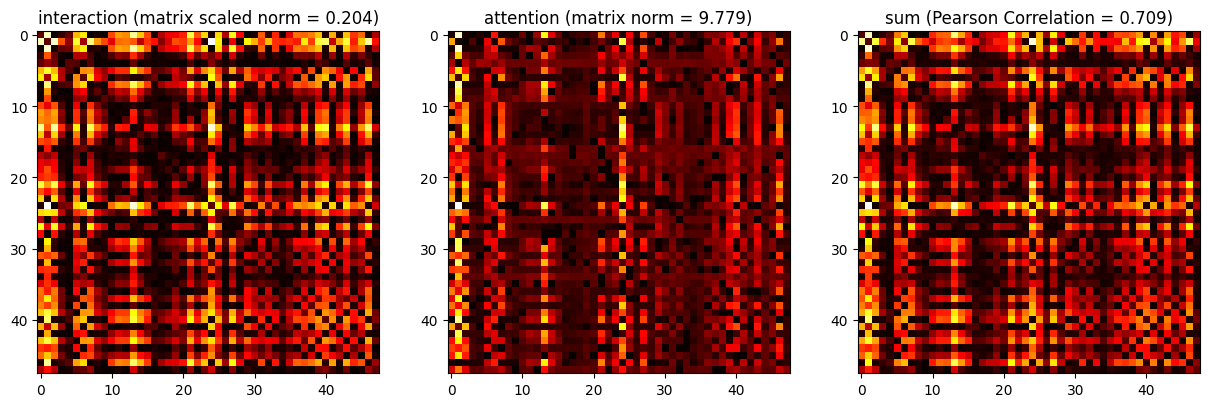

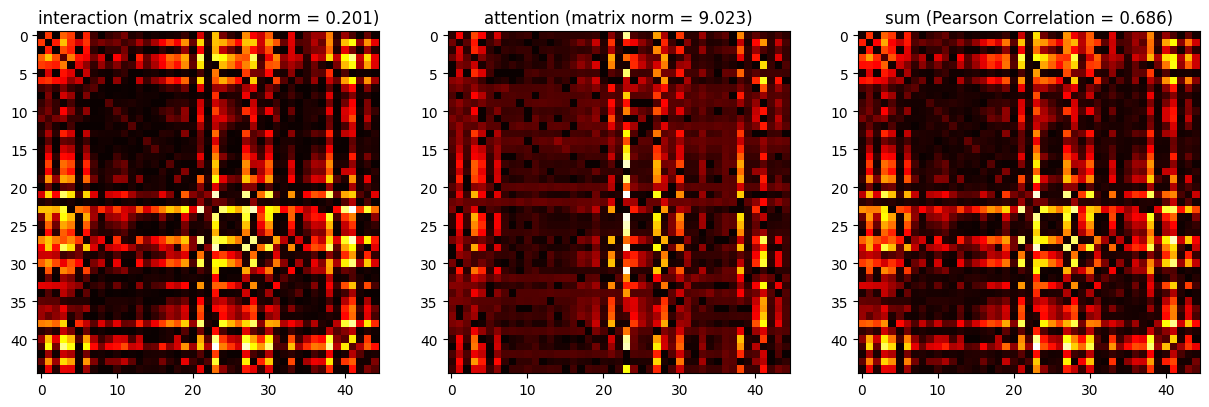

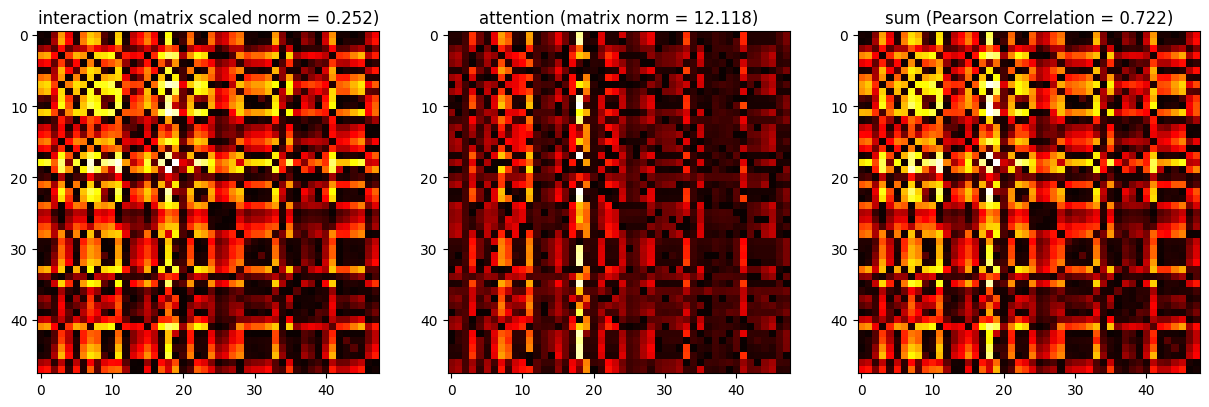

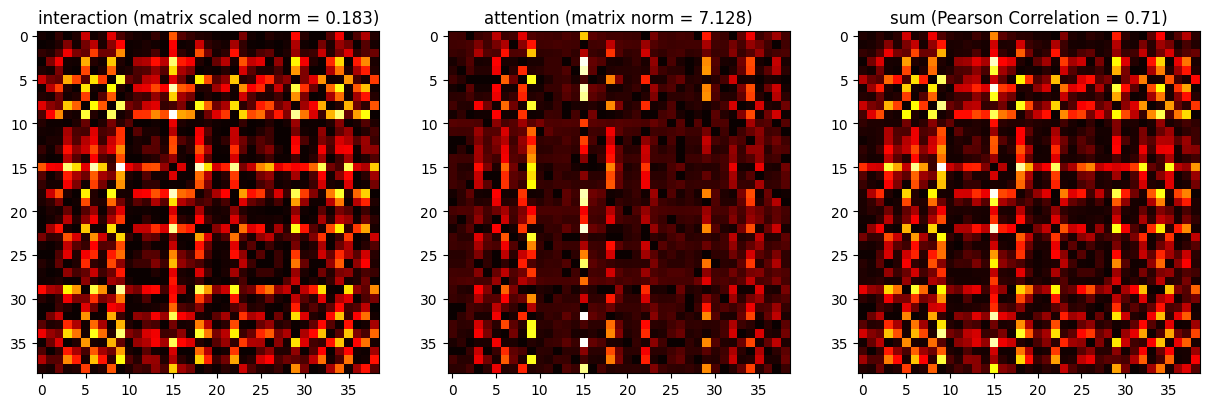

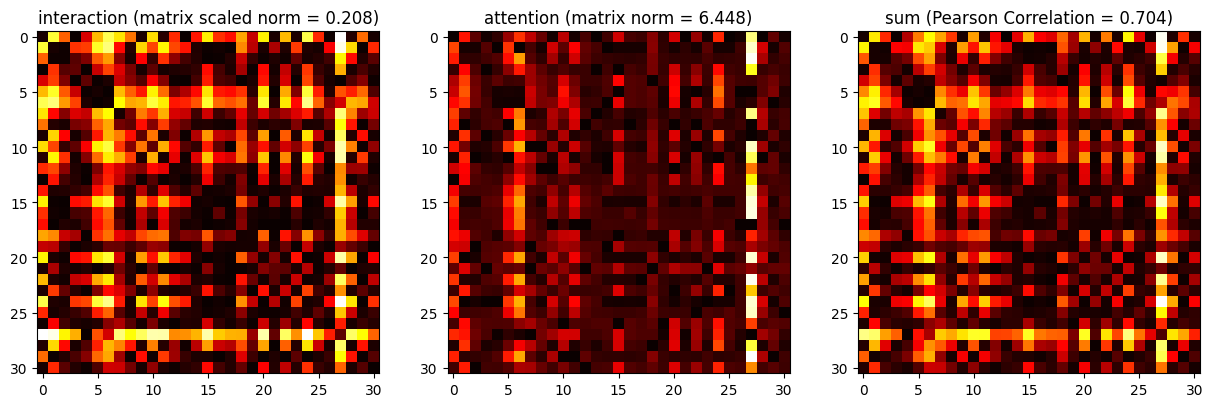

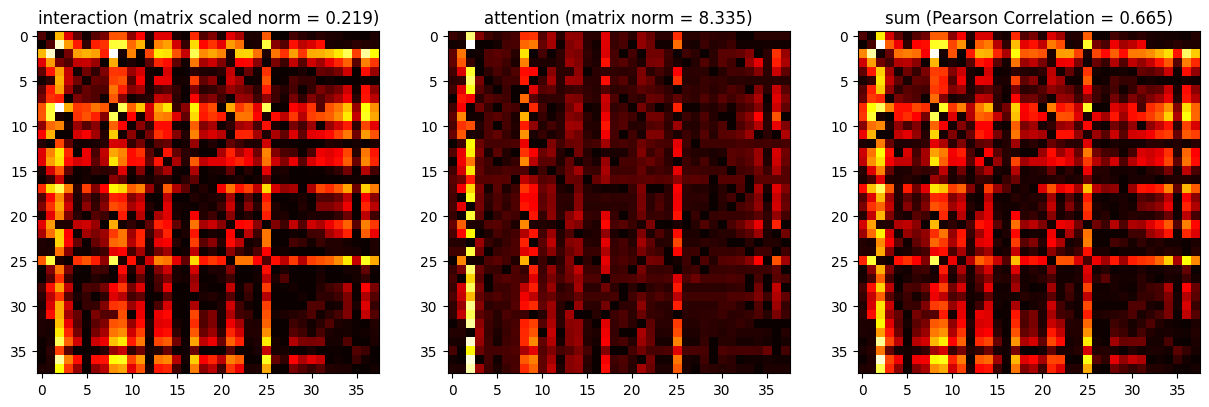

In [287]:
#model with pairs

for x in range(0,30):
    num = 0
    for b in np.squeeze(x_mask_test[x]):
        if b == 0:
            break
        num = num + 1
    pearson = scipy.stats.pearsonr(newInteraction[x,0:num,0:num].flatten(), newAttention[x,0:num,0:num].flatten())

    distance = np.linalg.norm(newInteraction[x,0:num,0:num] - newAttention[x,0:num,0:num])
    plt.figure(figsize = (15,15))
    plt.subplot(1, 3, 1)   
    plt.imshow(newInteraction[x,0:num,0:num],cmap = 'hot', interpolation = 'nearest')
    plt.title('interaction'+ ' (matrix scaled norm = ' + str(np.round(distance/num,3)) + ')')
   
    plt.subplot(1,3, 2)
    plt.imshow(newAttention[x,0:num,0:num],cmap = 'hot', interpolation = 'nearest')
    plt.title('attention' + ' (matrix norm = ' + str(np.round(distance,3)) + ')')
   
    plt.subplot(1,3,3)
    plt.imshow(newSum[x,0:num,0:num], cmap = 'hot', interpolation = 'nearest')
    plt.title('sum' + ' (Pearson Correlation = ' + str(np.round(pearson[0],3)) + ')')


    






In [285]:
torch.save(model,'torchModelNoPairParticleTransformer.h5')



In [157]:
import matplotlib.pyplot as plt

In [158]:
def learningCurve(trainloss,valloss):
    plt.figure(figsize=(10,8))
    plt.plot(trainloss)
    plt.plot(valloss)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

In [160]:
label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']


In [161]:
def makeRoc(features1,feat2,feat3,feat4, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model(torch.from_numpy(features1),torch.from_numpy(feat2),torch.from_numpy(feat3),torch.from_numpy(feat4))
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    g = labels_pred.detach().numpy()
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = g[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'Particle Transformer (No Pairs) ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

In [162]:
import pandas as pd

2024-04-25 13:34:31 | INFO | numexpr.utils | Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-04-25 13:34:31 | INFO | numexpr.utils | NumExpr defaulting to 8 threads.


In [163]:
makeRoc(x_points_test,x_part_test,x_jet_test,x_mask_test,y_test,label_list, model)

TypeError: 'tuple' object is not callable

tensor([[-1.3803,  5.5610,  1.1882,  ..., -1.1805,  0.5907, -2.9432],
        [ 1.6226,  0.5982,  2.1358,  ...,  2.9480, -4.0195, -4.5555],
        [ 3.7289, -2.6941,  1.0058,  ...,  2.6897, -0.1171, -6.1716],
        ...,
        [-0.9774,  2.4640, -2.4252,  ..., -0.9974, -0.6038,  8.3955],
        [ 0.6318,  2.6716, -0.0493,  ..., -2.2571,  0.7680, -2.4796],
        [ 1.9426, -1.2492,  0.5716,  ...,  0.1889, -2.3607, -4.2989]],
       grad_fn=<AddmmBackward0>)

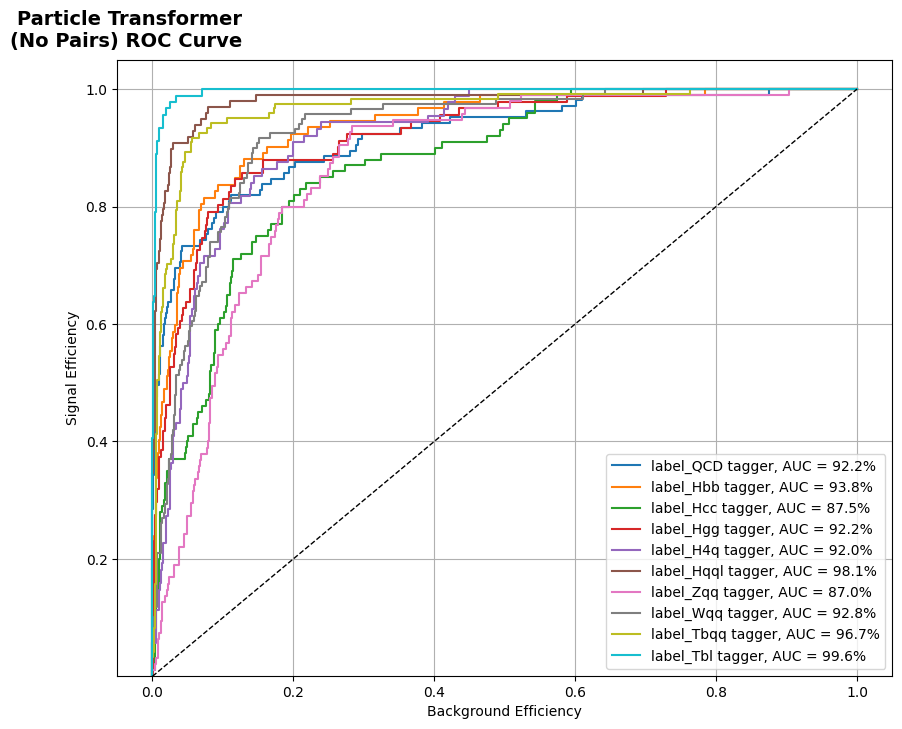

In [51]:
makeRoc(x_points_test,x_part_test,x_jet_test,x_mask_test,y_test,label_list, model)

In [79]:
x = model.getAttention()

AttributeError: 'ParticleTransformerWrapper' object has no attribute 'getAttention'

In [80]:
x 

<bound method ParticleTransformer.getAttention of ParticleTransformer(
  (trimmer): SequenceTrimmer()
  (embed): Embed(
    (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (embed): Sequential(
      (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=17, out_features=32, bias=True)
      (2): GELU(approximate='none')
      (3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): GELU(approximate='none')
      (6): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (7): Linear(in_features=32, out_features=32, bias=True)
      (8): GELU(approximate='none')
    )
  )
  (blocks): ModuleList(
    (0-1): 2 x Block(
      (pre_attn_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
      )
   

PearsonRResult(statistic=nan, pvalue=nan)

In [464]:
from thop import profile

In [472]:
x,y = profile(model[0], inputs=(x_points_test,x_part_test,x_jet_test,x_mask_test))

[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


AttributeError: 'numpy.ndarray' object has no attribute 'bool'

In [212]:
one = np.zeros([60,60]) + 0.3
two = np.zeros([60,60]) + 0.1

In [211]:
pearson = scipy.stats.pearsonr(one, two)


/Users/anrunw/miniconda3/envs/pytorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [198]:
np.linalg.norm(one)

18.00000000000027

In [186]:
np.linalg.norm(one - two)

12.000000000000005

In [187]:
17.5/35


0.5

In [188]:
7/35

0.2

In [189]:
12/60

0.2